First install the repo and requirements.

In [ ]:
%pip --quiet install git+https://github.com/wilson-labs/cola.git

# 2nd order optimization of neural nets using Gauss Newton

In this notebook we will show to easily build 2nd order optimizers using cola.

First let's generate a suitable classification dataset.


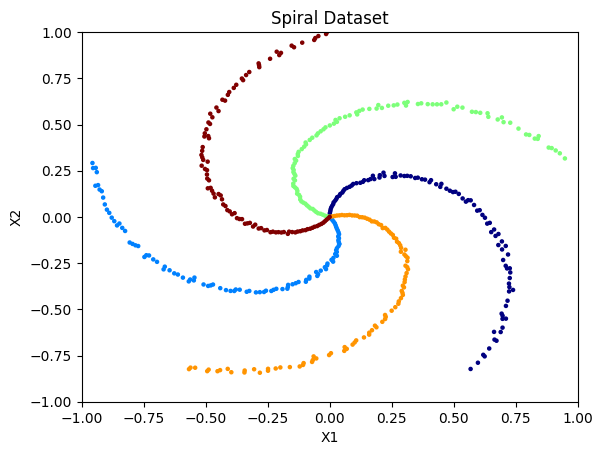

In [1]:
%load_ext autoreload
%autoreload 2

# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Function to generate the spiral dataset
def generate_spiral_data(n_points, n_spirals, noise=0.02):
    X = np.zeros((n_points * n_spirals, 2))
    y = np.zeros(n_points * n_spirals, dtype=int)
    delta_theta = 4 * np.pi / n_spirals
    for i in range(n_spirals):
        theta = np.linspace(i * delta_theta, (i + 1) * delta_theta, n_points)
        r = np.linspace(0.0, 1, n_points)
        t = theta + np.random.randn(n_points) * noise
        X[i * n_points:(i + 1) * n_points] = np.column_stack((r * np.sin(t), r * np.cos(t)))
        y[i * n_points:(i + 1) * n_points] = i
    return X, y

# Generating the spiral dataset with 100 points and 5 spirals
n_points = 100
n_spirals = 5
X, y = generate_spiral_data(n_points, n_spirals)

# Plotting the spiral dataset
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='jet', s=5)
plt.title('Spiral Dataset')
plt.xlabel('X1')
plt.ylabel('X2')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)
def MLP(k=200):
    return nn.Sequential(
                nn.Linear(2, k), nn.SiLU(),
                nn.Linear(k, k), nn.SiLU(),
                nn.Linear(k, n_spirals))
                

First lets train using 1000 epochs of SGD and Adam for comparison

In [3]:
learning_rate = 1e-2
epochs = 500

model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
adam_losses = []
for epoch in range(epochs):
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, y)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    adam_losses.append(loss.item())
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}')


Epoch [100/500], Loss: 0.0317324697971344
Epoch [200/500], Loss: 0.04851977527141571
Epoch [300/500], Loss: 0.019817877560853958
Epoch [400/500], Loss: 0.018510127440094948
Epoch [500/500], Loss: 0.017751768231391907


Now lets make a 2nd order method using cola, here we will use the Gauss-Newton approximation to the Hessian as well the PSD Fisher matrix.

First let's make it so we can call as an explicit function of it's parameters (like in jax).

In [4]:
import torch.func as tf

def flatten_params(params):
    shapes = [p.shape for p in params]
    flat_params = torch.cat([p.flatten() for p in params])
    return flat_params, shapes


def unflatten_params(flat_params, shapes):
    params = []
    i = 0
    for shape in shapes:
        size = torch.prod(torch.tensor(shape)).item()
        param = flat_params[i:i + size]
        param = param.view(shape)
        params.append(param)
        i += size
    return params

model = MLP()
flat_p, shape = flatten_params(list(model.parameters()))
flat_p = flat_p.detach().requires_grad_(True)

def stateless_model(flatparams, x):
    params = unflatten_params(flatparams, shape)
    names = list(n for n, _ in model.named_parameters())
    nps = {n: p for n, p in zip(names, params)}
    return tf.functional_call(model, nps, x)

Now let's construct the Gauss Newton matrix to use as a PSD proxy for the Hessian in Newtons method.

$G = \sum_i J(x_i)^THJ(x_i)$ where $J\in \mathbb{R}^{C \times p}$ is the Jacobian of the network for a single data point, $p$ is the number of parameters and $C$ is the number of outputs (classes).
Here $H$ is the Hessian of the loss function with respect to the logits.

Alternatively, we might consider Natural gradient descent (using the Fisher information matrix $F$).

Here we will annotate the matrices as PSD so as to enable more efficient inversion methods, and we will add a small amount of Tikhonov regularization to the diagonal to improve the conditioning.

In [5]:
import cola

def flat_fn(p):
    return stateless_model(p, X).reshape(-1)

def GN(p):
    """Gauss-Newton approximation to the Hessian"""
    J = cola.ops.Jacobian(flat_fn, p)
    loss = lambda z: criterion(z.reshape(X.shape[0],-1),y)*n_spirals
    H = cola.ops.Hessian(loss, flat_fn(p))
    G = J.T @ H @ J
    return cola.PSD(G+1e-3*cola.ops.I_like(G))

def Fisher(p):
    F = cola.ops.FIM(lambda p: stateless_model(p, X), p)
    return cola.PSD(F+1e-3*cola.ops.I_like(F))

def flat_loss(params):
    return criterion(flat_fn(params).reshape(X.shape[0],-1), y)

We can check the eigenvalues of GN and F to make sure they are not too big. Note that these matrices are already very big (40k x 40k), already far too large to use a dense method.

In [6]:
print(GN(flat_p).shape)

(41805, 41805)


Let's check that the matrices are of a sensible scale via their largest eigenvalues:

In [8]:
from cola import Auto
with torch.no_grad():
    print(f"GN eigmax: {cola.eigmax(GN(flat_p), alg=Auto(tol=1e-2))}")
    print(f"Fisher eigmax: {cola.eigmax(Fisher(flat_p), alg=Auto(tol=1e-2))}")

GN eigmax: 2.8789467811584473
Fisher eigmax: 0.5777260065078735


Below we implement the optimization loop in this stateless manner.

We limit the tolerance and max iterations of the (iterative) solves so as to reduce the computation time. Though we don't do so here, adding a preconditioner (e.g. Jacobi, PivotedCholesky, Nystrom) would substantially accelerate the convergence of the solves.
Let's compare the two second order methods:

In [9]:
from cola import Auto, CG
# Method 1: Hessian weighted Gauss Newton
p = flat_p.clone()

gnh_losses = []
for epoch in range(epochs//5):
    with torch.no_grad(): # don't pay extra memory for recording the computation graph
        g = torch.func.grad(flat_loss)(p)
        p -= cola.inv(GN(p),alg=Auto(tol=1e-3, max_iters=20)) @ g
        loss = flat_loss(p)
        gnh_losses.append(loss.item())
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}')

Epoch [10/500], Loss: 0.3142242431640625
Epoch [20/500], Loss: 0.08766728639602661
Epoch [30/500], Loss: 0.03646586090326309
Epoch [40/500], Loss: 0.022148877382278442
Epoch [50/500], Loss: 0.018077930435538292
Epoch [60/500], Loss: 0.01689857430756092
Epoch [70/500], Loss: 0.0165044367313385
Epoch [80/500], Loss: 0.016341200098395348
Epoch [90/500], Loss: 0.016260594129562378
Epoch [100/500], Loss: 0.016215266659855843


In [10]:
# Method 2: Natural gradient descent
p = flat_p.clone()

natural_gradient_losses = []
for epoch in range(epochs//5):
    with torch.no_grad(): # don't pay extra memory for recording the computation graph
        g = torch.func.grad(flat_loss)(p)
        p -= .5*cola.inv(Fisher(p),alg=Auto(tol=1e-3, max_iters=20)) @ g

        loss = flat_loss(p)
        natural_gradient_losses.append(loss.item())
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}')

Epoch [10/500], Loss: 0.08653374761343002
Epoch [20/500], Loss: 0.023038014769554138
Epoch [30/500], Loss: 0.018084317445755005
Epoch [40/500], Loss: 0.0170273520052433
Epoch [50/500], Loss: 0.016643397510051727
Epoch [60/500], Loss: 0.01646246947348118
Epoch [70/500], Loss: 0.016362380236387253
Epoch [80/500], Loss: 0.016300752758979797
Epoch [90/500], Loss: 0.016259804368019104
Epoch [100/500], Loss: 0.016231024637818336


Performing solves with these matrices for the 2nd order methods, we see that the optimization converges much faster per iteration than Adam.

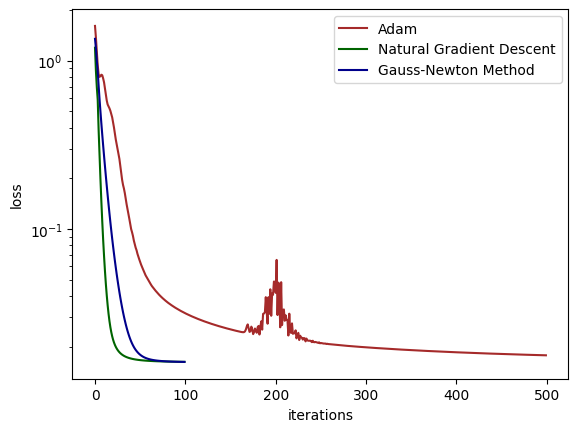

In [11]:
plt.plot(adam_losses, label='Adam', color='brown')
plt.plot(natural_gradient_losses, label='Natural Gradient Descent', color='darkgreen')
plt.plot(gnh_losses, label='Gauss-Newton Method', color='darkblue')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.yscale('log')
plt.legend()

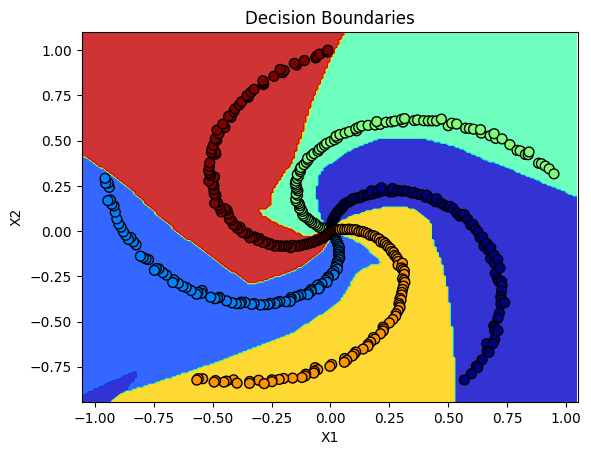

In [12]:
def plot_decision_boundary(model, X, y):
    # Creating a mesh grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predicting the class labels for the mesh grid
    Z = stateless_model(p, torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))
    Z = torch.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)

    # Plotting the decision boundaries
    plt.contourf(xx, yy, Z.detach().numpy(), alpha=0.8, cmap='jet')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=50, linewidth=1, cmap='jet')
    plt.xlim(X[:, 0].min() - 0.1, X[:, 0].max() + 0.1)
    plt.ylim(X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)
    plt.title('Decision Boundaries')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

# Plotting the decision boundaries
from functools import partial
plot_decision_boundary(partial(stateless_model,p), X, y)